In [2]:
#conda update python

In [3]:
#pip install numpy
#pip install matplotlib
#pip install sklearn

# Лабораторная работа №6  
## Метод главных компонент (PCA) и kNN  
Нестерович Василий Анатольевич  
НПМбв-01-22

Цель работы: реализовать метод главных компонент и алгоритм k-ближайших соседей
и применить их к задаче распознавания рукописных цифр MNIST.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from mnist import load_mnist

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
# Загрузка датасета
train, validation, test = load_mnist()

X_train, y_train = train
X_val, y_val = validation
X_test, y_test = test

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [6]:
# Приведение данных к нужной форме
X_train = X_train.reshape(X_train.shape[0], -1)
X_val   = X_val.reshape(X_val.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)

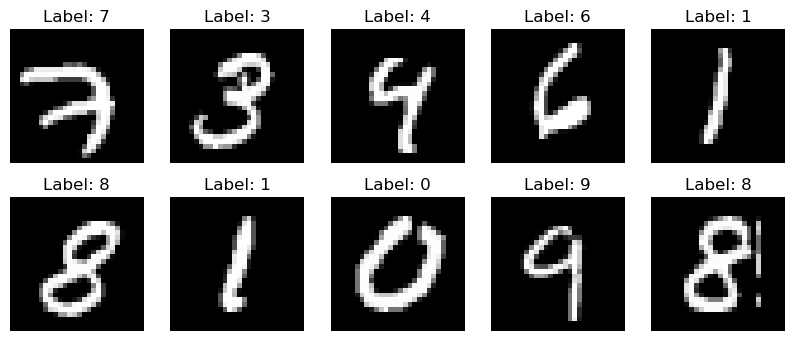

In [7]:
# Отобразим цифры из MNIST
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')

plt.show()


In [8]:
class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None

    def fit(self, X):
        # 1. Центрирование
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        # 2. SVD
        # X = U S V^T
        U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

        # 3. Собственные значения (дисперсии)
        n_samples = X.shape[0]
        eigenvalues = (S ** 2) / (n_samples - 1)

        # 4. Выбор числа компонент
        if self.n_components is not None:
            self.components_ = Vt[:self.n_components]
            self.explained_variance_ = eigenvalues[:self.n_components]
        else:
            self.components_ = Vt
            self.explained_variance_ = eigenvalues

        return self

    def transform(self, X):
        X_centered = X - self.mean_
        return np.dot(X_centered, self.components_.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [9]:
pca = my_PCA()
pca.fit(X_train)

eigenvalues = pca.explained_variance_


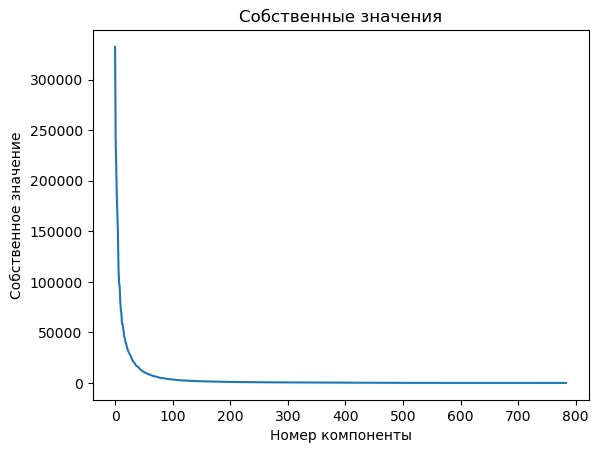

In [10]:
plt.plot(eigenvalues)
plt.title("Собственные значения")
plt.xlabel("Номер компоненты")
plt.ylabel("Собственное значение")
plt.show()

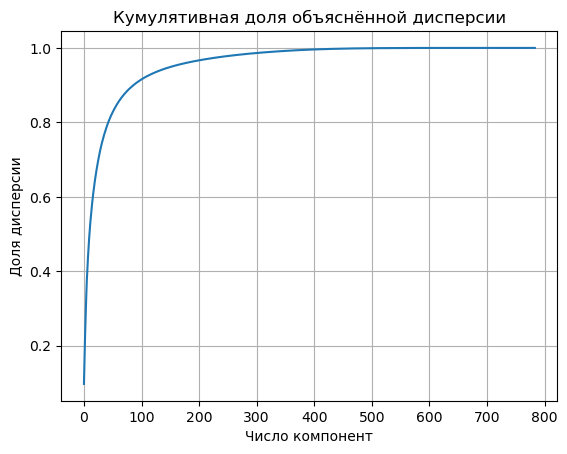

Доля дисперсии первых 15 компонент: 0.5791247436307819


In [11]:
cum_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)

plt.plot(cum_var)
plt.title("Кумулятивная доля объяснённой дисперсии")
plt.xlabel("Число компонент")
plt.ylabel("Доля дисперсии")
plt.grid()
plt.show()

print("Доля дисперсии первых 15 компонент:", cum_var[14])

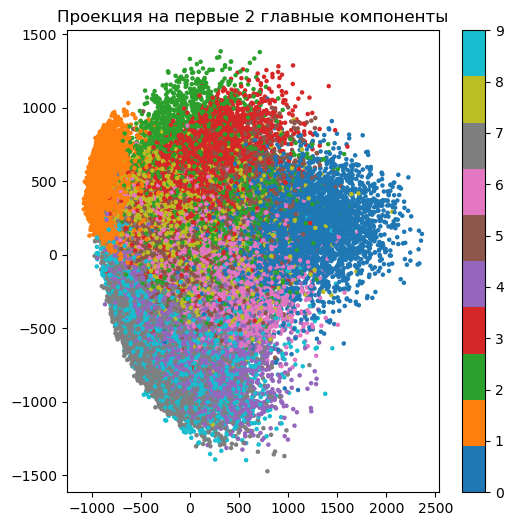

In [12]:
pca_2 = my_PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_train)

plt.figure(figsize=(6, 6))
scatter = plt.scatter(
    X_pca_2[:, 0],
    X_pca_2[:, 1],
    c=y_train,
    cmap='tab10',
    s=5
)
plt.colorbar(scatter)
plt.title("Проекция на первые 2 главные компоненты")
plt.show()

In [13]:
class my_kNN:
    def __init__(self, n_neighbors=5, batch_size=200):
        self.n_neighbors = n_neighbors
        self.batch_size = batch_size
        self.X_train = None
        self.y_train = None
        self.train_norms = None

    def fit(self, X, y):
        self.X_train = X.astype(np.float32)
        self.y_train = y
        self.train_norms = np.sum(self.X_train ** 2, axis=1)
        return self

    def predict(self, X):
        X = X.astype(np.float32)
        n_test = X.shape[0]
        y_pred = []

        for start in range(0, n_test, self.batch_size):
            end = start + self.batch_size
            X_batch = X[start:end]

            # ||x||^2
            test_norms = np.sum(X_batch ** 2, axis=1)

            # ||x - y||^2 = ||x||^2 + ||y||^2 - 2 x·y
            distances = (
                test_norms[:, None]
                + self.train_norms[None, :]
                - 2 * X_batch @ self.X_train.T
            )

            # k ближайших
            k_idx = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
            k_labels = self.y_train[k_idx]

            # голосование
            for labels in k_labels:
                values, counts = np.unique(labels, return_counts=True)
                y_pred.append(values[np.argmax(counts)])

        return np.array(y_pred)


In [14]:
knn = my_kNN(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Точность kNN без PCA:", acc)


Точность kNN без PCA: 0.9679


In [15]:
pca = my_PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

knn = my_kNN(n_neighbors=5)
knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print("Точность kNN + PCA:", acc)

Точность kNN + PCA: 0.9756


In [16]:
components_range = range(1, 65)
neighbors_range = range(1, 31)

accuracy = np.zeros((len(components_range), len(neighbors_range)))

In [17]:
components_range = range(1, 65)   # 1..64
neighbors_range = range(1, 31)    # 1..30

accuracy_matrix = np.zeros((len(components_range), len(neighbors_range)))

# ===== PCA ОДИН РАЗ =====
max_components = max(components_range)
pca = my_PCA(n_components=max_components)

X_train_pca_full = pca.fit_transform(X_train)
X_test_pca_full = pca.transform(X_test)

# ===== параметры батчинга =====
batch_size = 200
n_test = X_test.shape[0]

# ===== перебор =====
for i, n_comp in enumerate(components_range):
    print(f"PCA components: {n_comp}")

    X_train_pca = X_train_pca_full[:, :n_comp].astype(np.float32)
    X_test_pca = X_test_pca_full[:, :n_comp].astype(np.float32)

    train_norms = np.sum(X_train_pca ** 2, axis=1)

    all_preds = {k: [] for k in neighbors_range}

    for start in range(0, n_test, batch_size):
        end = min(start + batch_size, n_test)

        X_batch = X_test_pca[start:end]
        test_norms = np.sum(X_batch ** 2, axis=1)

        # ||x - y||^2
        distances = (
            test_norms[:, None]
            + train_norms[None, :]
            - 2 * X_batch @ X_train_pca.T
        )

        # сортируем соседей один раз
        sorted_idx = np.argsort(distances, axis=1)

        for k in neighbors_range:
            k_labels = y_train[sorted_idx[:, :k]]

            for row in k_labels:
                values, counts = np.unique(row, return_counts=True)
                all_preds[k].append(values[np.argmax(counts)])

    # считаем accuracy для всех k
    for j, k in enumerate(neighbors_range):
        accuracy_matrix[i, j] = accuracy_score(y_test, all_preds[k])

print("Максимальная точность:", accuracy_matrix.max())


PCA components: 1
PCA components: 2
PCA components: 3
PCA components: 4
PCA components: 5
PCA components: 6
PCA components: 7
PCA components: 8
PCA components: 9
PCA components: 10
PCA components: 11
PCA components: 12
PCA components: 13
PCA components: 14
PCA components: 15
PCA components: 16
PCA components: 17
PCA components: 18
PCA components: 19
PCA components: 20
PCA components: 21
PCA components: 22
PCA components: 23
PCA components: 24
PCA components: 25
PCA components: 26
PCA components: 27
PCA components: 28
PCA components: 29
PCA components: 30
PCA components: 31
PCA components: 32
PCA components: 33
PCA components: 34
PCA components: 35
PCA components: 36
PCA components: 37
PCA components: 38
PCA components: 39
PCA components: 40
PCA components: 41
PCA components: 42
PCA components: 43
PCA components: 44
PCA components: 45
PCA components: 46
PCA components: 47
PCA components: 48
PCA components: 49
PCA components: 50
PCA components: 51
PCA components: 52
PCA components: 53
PC

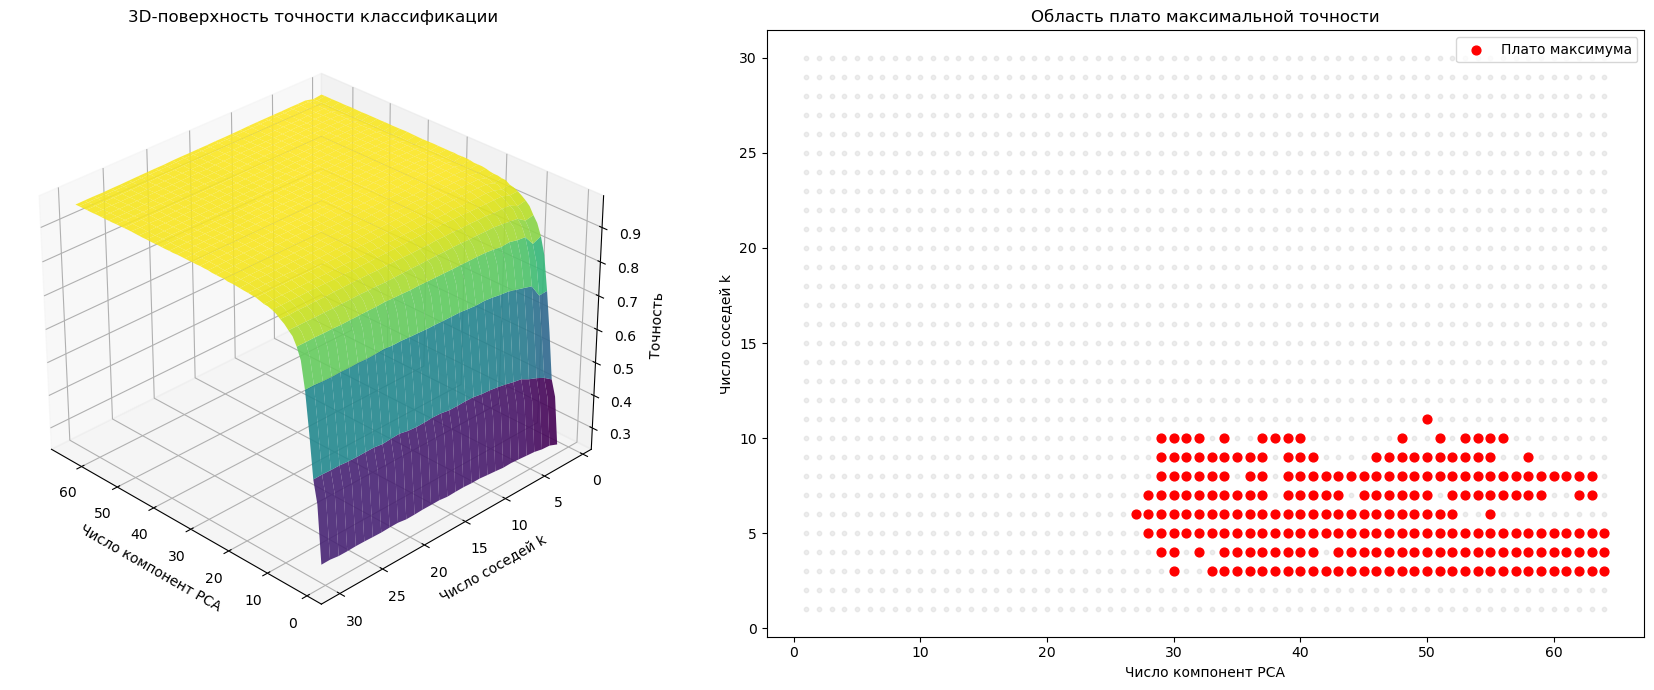

In [23]:
from mpl_toolkits.mplot3d import Axes3D

# --- максимум и плато ---
max_acc = accuracy_matrix.max()
eps = 0.002  # 0.2%
plateau_mask = accuracy_matrix >= (max_acc - eps)

# --- сетка ---
components, neighbors = np.meshgrid(
    list(components_range),
    list(neighbors_range),
    indexing='ij'
)

# --- фигура ---
fig = plt.figure(figsize=(18, 7))

# ===== 3D поверхность =====
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.plot_surface(
    components,
    neighbors,
    accuracy_matrix,
    cmap='viridis',
    edgecolor='none',
    alpha=0.9
)

ax1.set_xlabel("Число компонент PCA")
ax1.set_ylabel("Число соседей k")
ax1.set_zlabel("Точность")
ax1.set_title("3D-поверхность точности классификации")

ax1.view_init(elev=30, azim=135)

# ===== Плато максимума =====
ax2 = fig.add_subplot(1, 2, 2)

ax2.scatter(
    components[plateau_mask],
    neighbors[plateau_mask],
    c='red',
    s=40,
    label="Плато максимума"
)

ax2.scatter(
    components[~plateau_mask],
    neighbors[~plateau_mask],
    c='lightgray',
    s=10,
    alpha=0.4
)

ax2.set_xlabel("Число компонент PCA")
ax2.set_ylabel("Число соседей k")
ax2.set_title("Область плато максимальной точности")
ax2.legend()

plt.tight_layout()
plt.show()


## Вывод. Анализ зависимости точности от параметров PCA и kNN

Слева показан график зависимости точности kNN от числа компонент и числа k соседей.
Справа — области значений соседей и компонент, при которых с незначительной погрешностью 
достигается максимальная точность.

3D-график показывает, что точность классификации возрастает при увеличении
числа главных компонент и достигает насыщения в диапазоне примерно 25–30 компонент.
Дальнейшее увеличение размерности пространства признаков не приводит к существенному
росту качества классификации.

Выделенная область плато максимальной точности демонстрирует, что существует
набор параметров (число компонент PCA и число соседей k), при которых достигается
практически одинаковая максимальная точность. Это свидетельствует о стабильности
алгоритма и слабой чувствительности к точному выбору гиперпараметров.

Таким образом, применение PCA позволяет эффективно уменьшить размерность данных,
сохранив высокую точность классификации, а также упростить выбор параметров
алгоритма kNN.
